https://github.com/llSourcell/How_to_simulate_a_self_driving_car

https://www.youtube.com/watch?v=EaY5QiZwSP4&t=930s

https://github.com/naokishibuya

https://www.computervision.zone/courses/self-driving-simulation-using-nvidias-model/

#IMPORTANTO OS DADOS

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Downloading...
From: https://drive.google.com/uc?id=1I7hXUkc6S9KD2ZebB0f4zRv0ZWry160G
To: /content/my-self-drive-car.zip
100% 1.87G/1.87G [00:12<00:00, 155MB/s] 


In [ ]:
!unzip -q 'gdrive/MyDrive/dataset/my-self-drive-car.zip' -d "data"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_073.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_146.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_218.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_291.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_365.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_437.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_512.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_584.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_656.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_729.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_801.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_871.jpg  
  inflating: my-self-drive-car/IMG/right_2022_01_08_15_39_50_943.jpg  
  inflating: my-se

# BIBLIOTECAS

In [ ]:
import os
import pandas as pd 
import numpy as np 
import random

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import cv2
import matplotlib.image as mpimg

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
path = "data/my-self-drive-car"
path_imgs = path + "IMG/"

In [ ]:
df = pd.read_csv(path + "/driving_log.csv",  names=['center','left','right','steering','throttle','brake','speed'])

In [ ]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,0.0,1.0,0.0,7.786190
1,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,0.0,1.0,0.0,8.218476
2,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,0.0,1.0,0.0,9.131496
3,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,0.0,1.0,0.0,9.898218
4,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,D:\GOOGLE DRIVE\Python-Projects\autonomous-car...,0.0,1.0,0.0,10.638420


# PRÉ-PROCESSAMENTO

In [ ]:
def getName(filePath):
    return filePath.split("\\")[-1]

In [ ]:
columns = ['center','left','right','steering','throttle','brake','speed']
df = pd.read_csv(os.path.join(path, "driving_log.csv"),  names=columns)
df['center'] = df['center'].apply(getName)
df['left'] = df['left'].apply(getName)
df['right'] = df['right'].apply(getName)

print(df['center'][0])

print("Total de imagens importadas : {}".format(df.shape[0]))

center_2022_01_06_11_27_09_663.jpg
Total de imagens importadas : 39275


### BALANCEAMENTO DOS DADOS

[-1.         -0.93548387 -0.87096774 -0.80645161 -0.74193548 -0.67741935
 -0.61290323 -0.5483871  -0.48387097 -0.41935484 -0.35483871 -0.29032258
 -0.22580645 -0.16129032 -0.09677419 -0.03225806  0.03225806  0.09677419
  0.16129032  0.22580645  0.29032258  0.35483871  0.41935484  0.48387097
  0.5483871   0.61290323  0.67741935  0.74193548  0.80645161  0.87096774
  0.93548387  1.        ]


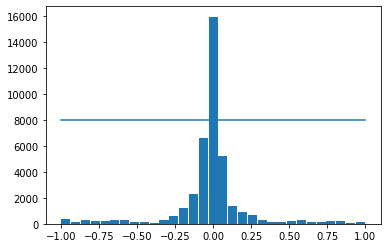

In [ ]:
nBins = 31
samplesPerBin = 8000

hist, bins = np.histogram(df['steering'], nBins)
print(bins)
    
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.06)
plt.plot((-1,1), (samplesPerBin,samplesPerBin))
plt.show()

### EXCLUINDO DADOS DESNECESSÁRIOS

In [ ]:
removeindexList = []
for j in range(nBins):
    binDataList = []
    for i in range(len(df['steering'])):
        if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j + 1]:
            binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeindexList.extend(binDataList)

print('Removed Images:', len(removeindexList))
df.drop(df.index[removeindexList], inplace=True)
print('Remaining Images:', len(df))

Removed Images: 7939
Remaining Images: 31336


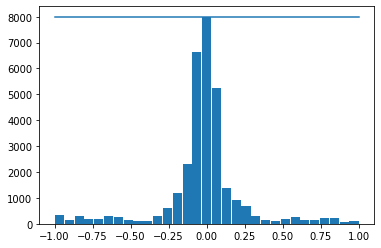

In [ ]:
hist, _ = np.histogram(df['steering'], (nBins))
plt.bar(center, hist, width=0.06)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samplesPerBin, samplesPerBin))
plt.show()

In [ ]:
def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]

        choice = np.random.choice(3)
        if choice == 0:
            imagesPath.append(os.path.join(path, 'IMG' ,indexed_data[0]))
            steering.append(float(indexed_data[3]))

        elif choice == 1:
            imagesPath.append(os.path.join(path, 'IMG' ,indexed_data[1]))
            steering.append(float(indexed_data[3])+0.2)

        else:
            imagesPath.append(os.path.join(path, 'IMG' ,indexed_data[1]))
            steering.append(float(indexed_data[3])-0.2)

    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)

    return imagesPath, steering

In [ ]:
X, y = loadData(path, df)

In [ ]:
X

array(['my-self-drive-car/IMG/left_2022_01_06_11_27_09_732.jpg',
       'my-self-drive-car/IMG/center_2022_01_06_11_27_09_952.jpg',
       'my-self-drive-car/IMG/left_2022_01_06_11_27_10_024.jpg', ...,
       'my-self-drive-car/IMG/left_2022_01_08_15_49_24_560.jpg',
       'my-self-drive-car/IMG/left_2022_01_08_15_49_24_638.jpg',
       'my-self-drive-car/IMG/center_2022_01_08_15_49_24_710.jpg'],
      dtype='<U56')

##CRIANDO CONJUTOS DE TREINO E TESTE

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.2, random_state=10)
print('Total Training Images: ', len(xTrain))
print('Total Validation Images: ', len(xVal))

Total Training Images:  25068
Total Validation Images:  6268


#PRE-PROCESSAMENTO 
#DATA AUGMENTATION 

In [ ]:
def preProcess(img):
    img = img[60:135,:,:] #CROP
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #RGB TO YUV
    img = cv2.GaussianBlur(img,  (3, 3), 0) # BLUR
    img = cv2.resize(img, (200, 66)) #RESIZE
    img = img/255
    return img

In [ ]:
def augmentImage(imgPath,steering):
    img = mpimg.imread(imgPath)

    #PAN
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)

    #ZOOM
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)

    #BRIGHTNESS
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)

    #FLIP
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering

    return img, steering

In [ ]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)

            if trainFlag: #APLICA DATA AUG NO TREINO
                img, steering = augmentImage(imagesPath[index], steeringList[index])

            else: # CARREGA IMAGEM NA VALIDAÇÃO
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]

            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)

        yield (np.asarray(imgBatch), np.asarray(steeringBatch))




#HIPERPARÂMETROS

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

EPOCHS = 50
BATCH_SIZE = 64
alpha  = 1e-5

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='elu', padding="same", input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128,(3, 3), activation='elu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='elu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='elu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, (1, 1), activation='elu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(258, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 200, 64)       4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 100, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 33, 100, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 100, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 50, 128)      0         
 2D)                                                             
                                                        

In [ ]:
model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae', 'mse'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=alpha, patience=5, verbose=1)

In [ ]:
stopping = EarlyStopping(monitor="val_loss", min_delta=alpha, patience=15, verbose=1)

In [ ]:
callbacks = [checkpoint, lr_reduce, stopping]

In [ ]:
history = model.fit(batchGen(xTrain, yTrain,batchSize=100, trainFlag=1),

                    steps_per_epoch=300,
                    epochs=50,
                    validation_data=batchGen(xVal, yVal, batchSize=100, trainFlag=0),
                    validation_steps=200,
                    callbacks = callbacks
                    )

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.4073 - mae: 0.3679 - mse: 0.4073
Epoch 00001: val_loss improved from inf to 0.11105, saving model to model.h5
300/300 [==============================] - 263s 833ms/step - loss: 0.4073 - mae: 0.3679 - mse: 0.4073 - val_loss: 0.1111 - val_mae: 0.2535 - val_mse: 0.1111 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.0960 - mae: 0.2384 - mse: 0.0960
Epoch 00002: val_loss did not improve from 0.11105
300/300 [==============================] - 249s 830ms/step - loss: 0.0960 - mae: 0.2384 - mse: 0.0960 - val_loss: 0.1545 - val_mae: 0.3240 - val_mse: 0.1545 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.0785 - mae: 0.2185 - mse: 0.0785
Epoch 00003: val_loss improved from 0.11105 to 0.05814, saving model to model.h5
300/300 [==============================] - 254s 850ms/step - loss: 0.0785 - mae: 0.2185 - mse: 0.0785 - val_loss: 0.0581 - val_mae: 0.19

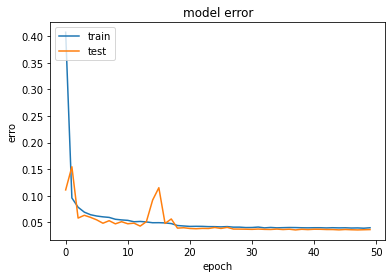

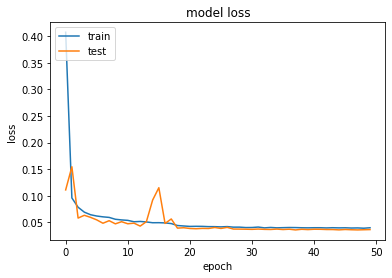

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('erro')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()